# Is Jensen-Shannon Divergence Concave for two Bernoulli Variables?

$D_{JS}(p_1 || p_2) = \frac{1}{2} \left[ p_1 \log_2 \frac{p_1}{m} + (1-p_1) \log_2 \frac{1-p_1}{1-m} \right] + \frac{1}{2} \left[ p_2 \log_2 \frac{p_2}{m} + (1-p_2) \log_2 \frac{1-p_2}{1-m} \right]$

$D_{JS}(p_1 || p_2) = \frac{1}{2} \left[ p_1 \log_2 \frac{p_1}{m} + (1-p_1) \log_2 \frac{1-p_1}{1-m} \right] + \frac{1}{2} \left[ p_2 \log_2 \frac{p_2}{m} + (1-p_2) \log_2 \frac{1-p_2}{1-m} \right]$

In [1]:
using PyPlot



n = 100
x = linspace(0,1,n)
y = linspace(0,1,n)

xgrid = repmat(x',n,1)
ygrid = repmat(y,1,n)

z = zeros(n,n)
for i=1:n
    for j=1:n
        z[i,j] = abs(dist_js_bernoulli(x[i],y[j]) - 0.2)
    end
end

INFO: Loading help data...


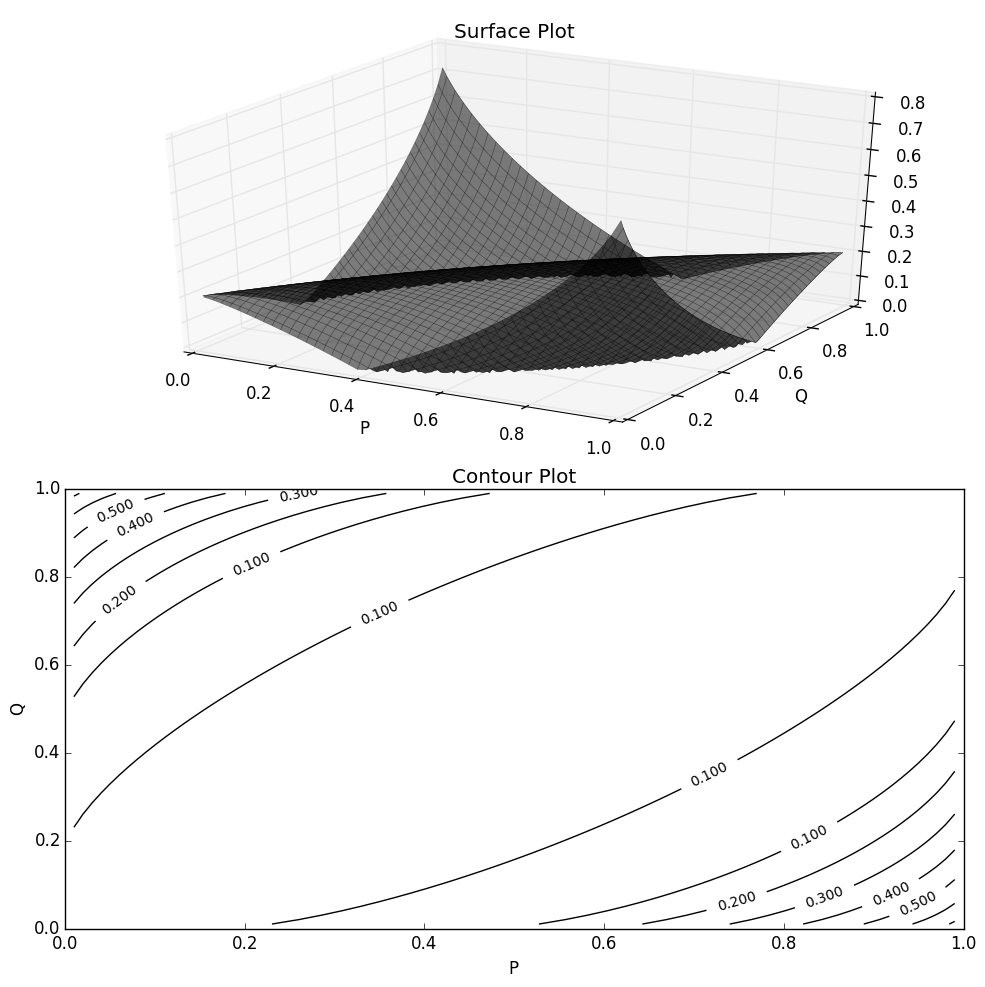

In [2]:
############
##  Plot  ##
############
fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](2,1,1, projection = "3d") 
ax[:plot_surface](xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.5, linewidth=0.25) 
xlabel("P") 
ylabel("Q")
title("Surface Plot")

subplot(212) 
ax = fig[:add_subplot](2,1,2) 
cp = ax[:contour](xgrid, ygrid, z, colors="black", linewidth=2.0) 
ax[:clabel](cp, inline=1, fontsize=10) 
xlabel("P") 
ylabel("Q")
title("Contour Plot")
tight_layout()

In [15]:
using Optim

function d_kl_bern(p,q)
    ## Kulback-Leibler divergence for two Bernoulli variables with probabilities p and q
    return p*log2(p./q)+(1-p)*log2((1-p)/(1-q))
end

function d_js_bern(p1,p2)
    ## Jenson-Shannon divergence for two Bernoulli variables with probabilities p1 and p2
    m = 0.5*(p1+p2)
    return 0.5*d_kl_bern(p1,m) + 0.5*d_kl_bern(p2,m)
end

function d_js_multivar_bern(x::Vector,y::Vector)
    ## Jenson-Shannon divergence for between first and 
    dist = 0
    for i=1:length(x)/2
        dist += d_js_bern(x[i],y[i])
    end
    return dist
end

function impose_bounds!(x::Vector)
    x[x.>1] = 1
    x[x.<=0] = eps()
end

function f(x::Vector)
    impose_bounds!(x)
    return abs(d_js_multivar_bern(x[1:end/2],x[1+end/2:end]))
end

function generate_probabilities(n,target;max_iter=20)
    ## n = number of methylation sites
    ## target = target Jensen-Shannon divergence
    df = Optim.autodiff(x->abs(f(x)-target), Float64, n*2)
    
    converged = false
    iter = 0
    y = NaN
    while !converged && iter < max_iter
        try
            y = fminbox(df,rand(n*2),zeros(n*2),ones(n*2))
            converged = true
        catch
            println("didnt converge, trying again")
            iter +=1
        end
    end
    if converged
        p1,p2 = y.minimum[1:end/2],y.minimum[1+end/2:end]
        return p1,p2
    else
        error("Unable to find solution")
    end
end

generate_probabilities (generic function with 1 method)

In [18]:
generate_probabilities(1000,3)

didnt converge, trying again
didnt converge, trying again
MultivariateOptimizationResults{Float64,1}
Final JS-divergence: 2.9999999999999996


In [19]:
error("Did not converge")

LoadError: Did not converge
while loading In[19], in expression starting on line 1